In [1]:
import os
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
import os
import random
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Initial previous code
data_dir = r"..\Datasets\kvasir-dataset-v2"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_subset_dataset(data_dir, transform, num_samples=20):
    class_dirs = [os.path.join(data_dir, d) for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    selected_images = []

    for class_dir in class_dirs:
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.jpg', '.png', '.jpeg'))]
        sampled_images = random.sample(images, min(num_samples, len(images)))
        for img_path in sampled_images:
            label = os.path.basename(class_dir)
            selected_images.append((img_path, label))
    
    return selected_images

class CustomDataset(datasets.VisionDataset):
    def __init__(self, selected_images, class_to_idx, transform=None):
        super().__init__(root=None, transform=transform)
        self.selected_images = selected_images
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.selected_images)

    def __getitem__(self, idx):
        img_path, label = self.selected_images[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label_idx = self.class_to_idx[label]
        return image, label_idx

selected_images = get_subset_dataset(data_dir, transform)
class_names = [os.path.basename(d) for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

subset_dataset = CustomDataset(selected_images, class_to_idx, transform=transform)
train_loader = DataLoader(subset_dataset, batch_size=32, shuffle=True)

print(f"Class names: {class_names}")

# Function to create the test subset
def create_test_subset(data_dir, class_to_idx, num_classes=8, num_samples_per_class=2):
    class_dirs = [os.path.join(data_dir, d) for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    selected_images = []

    for class_dir in class_dirs:
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.jpg', '.png', '.jpeg'))]
        sampled_images = random.sample(images, min(num_samples_per_class, len(images)))
        for img_path in sampled_images:
            label = os.path.basename(class_dir)
            selected_images.append((img_path, label))

    # Ensure we have 16 images in total, combining all classes
    excess_images = len(selected_images) - (num_classes * num_samples_per_class)
    if excess_images > 0:
        selected_images = selected_images[:-excess_images]
    
    return selected_images

# Creating the test subset
test_selected_images = create_test_subset(data_dir, class_to_idx)
test_subset_dataset = CustomDataset(test_selected_images, class_to_idx, transform=transform)
test_loader = DataLoader(test_subset_dataset, batch_size=32, shuffle=True)

print(f"Test subset created with {len(test_selected_images)} images")

Class names: ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']
Test subset created with 16 images


In [3]:
# 2. Feature Extractor (Base Network)
def build_base_network():
    base_model = models.resnet18(pretrained=True)
    base_model.fc = nn.Identity()  # Remove the fully connected layer
    return base_model


In [4]:
# 3. Compute Class Prototypes
def compute_class_prototypes(train_loader, base_network, class_names):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    base_network.eval()
    base_network.to(device)

    embeddings = {class_name: [] for class_name in class_names}

    with torch.no_grad():
        for images, labels in tqdm(train_loader, desc="Computing Class Prototypes"):
            images, labels = images.to(device), labels.to(device)
            features = base_network(images)
            for i, label in enumerate(labels):
                class_name = class_names[label.item()]
                embeddings[class_name].append(features[i].cpu())

    class_prototypes = {class_name: torch.mean(torch.stack(embeddings[class_name]), dim=0)
                        for class_name in class_names}
    return class_prototypes


In [5]:
# 4. Siamese Neural Network Definition
class SiameseNetwork(nn.Module):
    def __init__(self, base_network):
        super(SiameseNetwork, self).__init__()
        self.base_network = base_network
        self.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        img1, prototype = inputs  # img1 is a batch of images, prototype is 1D or expanded
        feature1 = self.base_network(img1)  # Extract features from batch of images
        distance = torch.abs(feature1 - prototype)  # Calculate absolute difference
        similarity = self.fc(distance)  # Calculate similarity
        return similarity


In [6]:
def train_snn_classification(model, train_loader, class_prototypes, class_names, epochs=10, save_path="snn_model.pth"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            batch_size = images.size(0)
            scores = torch.zeros(batch_size, len(class_names)).to(device)

            # Compute similarity scores with all class prototypes
            for i, class_name in enumerate(class_names):
                prototype = class_prototypes[class_name].to(device)
                similarities = model([images, prototype.expand(batch_size, -1)])
                scores[:, i] = similarities.squeeze()

            # Compute loss and backpropagate
            loss = criterion(scores, labels)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader)}")

    # Ensure save path directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Save the trained model
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

    return model

In [7]:
# 6. Inference Function
def classify_image_snn(image_path, model, class_prototypes, class_names):
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    img = Image.open(image_path).convert('RGB')
    input_img = transform(img).unsqueeze(0)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_img = input_img.to(device)
    model = model.to(device)

    similarity_scores = {}
    with torch.no_grad():
        for class_name, prototype in class_prototypes.items():
            prototype = prototype.unsqueeze(0).to(device)
            similarity = model([input_img, prototype])
            similarity_scores[class_name] = similarity.item()

    predicted_class = max(similarity_scores, key=similarity_scores.get)
    print(f"Similarity scores: {similarity_scores}")
    print(f"Predicted Class: {predicted_class}")

    plt.imshow(np.array(img))
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

    return predicted_class


In [8]:
# 7. Evaluation function
# Evaluate the model on the test subset and calculate accuracy
def evaluate_model(test_loader, model, class_prototypes, class_names):
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in test_loader:
            for img, target in zip(images, labels):
                # Save the image temporarily to disk (just for the inference function)
                temp_image_path = "temp_img.jpg"
                transforms.functional.to_pil_image(img).save(temp_image_path)

                # Use the existing classify_image_snn function
                predicted_class = classify_image_snn(temp_image_path, model, class_prototypes, class_names)
                predicted_class_idx = class_names.index(predicted_class)

                all_preds.append(predicted_class_idx)
                all_targets.append(target.item())

    accuracy = accuracy_score(all_targets, all_preds) * 100
    print(f"Model accuracy on the test subset: {accuracy:.2f}%")

In [9]:
if __name__ == "__main__":
    # Build the base network
    base_network = build_base_network()

    # Compute class prototypes
    print("Computing class prototypes...")
    class_prototypes = compute_class_prototypes(train_loader, base_network, class_names)

    # Save the prototypes
    torch.save(class_prototypes, "class_prototypes.pth")
    print("Class prototypes saved.")

    # Initialize and train the Siamese Network
    siamese_model = SiameseNetwork(base_network)
    print("Training the Siamese Network...")
    trained_model = train_snn_classification(
        siamese_model, 
        train_loader, 
        class_prototypes, 
        class_names, 
        epochs=10, 
        save_path="./models/snn_model.pth"
    )

G:\anaconda3\envs\Florence\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
G:\anaconda3\envs\Florence\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Computing class prototypes...


Computing Class Prototypes: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


Class prototypes saved.
Training the Siamese Network...
Epoch 1/10, Loss: 1.9867906332015992
Epoch 2/10, Loss: 1.7544302225112915
Epoch 3/10, Loss: 1.5929260015487672
Epoch 4/10, Loss: 1.5256792783737183
Epoch 5/10, Loss: 1.4689353704452515
Epoch 6/10, Loss: 1.4469549417495728
Epoch 7/10, Loss: 1.4211408138275146
Epoch 8/10, Loss: 1.399709153175354
Epoch 9/10, Loss: 1.4008779525756836
Epoch 10/10, Loss: 1.3934265851974488
Model saved to ./models/snn_model.pth


Similarity scores: {'dyed-lifted-polyps': 0.7741217613220215, 'dyed-resection-margins': 0.9993923902511597, 'esophagitis': 0.0072650848887860775, 'normal-cecum': 6.90469314577058e-05, 'normal-pylorus': 0.00020286931248847395, 'normal-z-line': 0.0023239573929458857, 'polyps': 0.0003186817921232432, 'ulcerative-colitis': 0.0029316535219550133}
Predicted Class: dyed-resection-margins


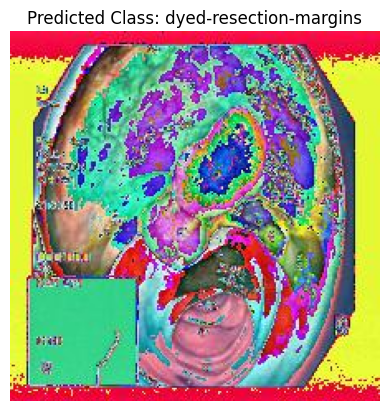

Similarity scores: {'dyed-lifted-polyps': 0.9067491292953491, 'dyed-resection-margins': 0.9998157620429993, 'esophagitis': 0.04645082727074623, 'normal-cecum': 0.0003856538387481123, 'normal-pylorus': 0.0015662042424082756, 'normal-z-line': 0.020864112302660942, 'polyps': 0.0018181301420554519, 'ulcerative-colitis': 0.010674000717699528}
Predicted Class: dyed-resection-margins


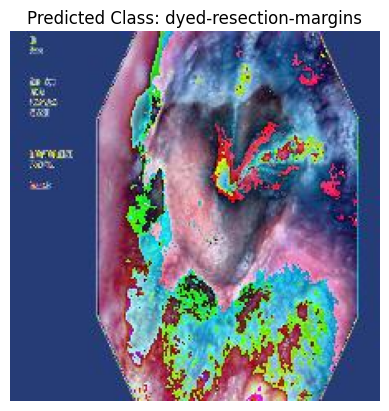

Similarity scores: {'dyed-lifted-polyps': 0.5983633995056152, 'dyed-resection-margins': 0.9976704716682434, 'esophagitis': 0.007942640222609043, 'normal-cecum': 4.64319164166227e-05, 'normal-pylorus': 0.0003099055902566761, 'normal-z-line': 0.0014071823097765446, 'polyps': 0.00014719254977535456, 'ulcerative-colitis': 0.002344188280403614}
Predicted Class: dyed-resection-margins


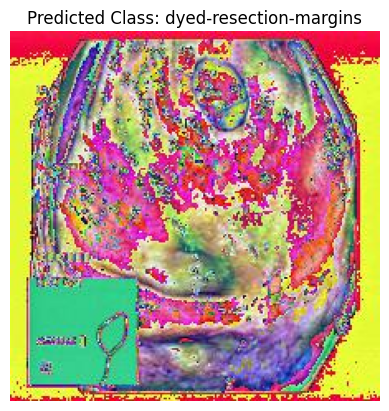

Similarity scores: {'dyed-lifted-polyps': 0.9801085591316223, 'dyed-resection-margins': 0.9999628067016602, 'esophagitis': 0.12159878760576248, 'normal-cecum': 0.0017298735911026597, 'normal-pylorus': 0.004496127367019653, 'normal-z-line': 0.05105151608586311, 'polyps': 0.0054874056950211525, 'ulcerative-colitis': 0.033515918999910355}
Predicted Class: dyed-resection-margins


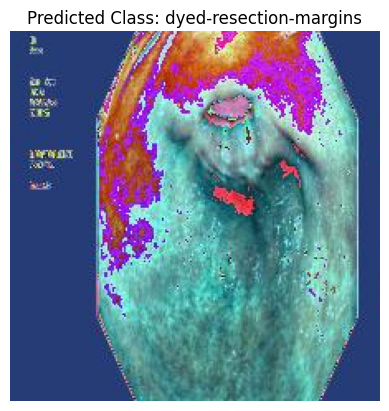

Similarity scores: {'dyed-lifted-polyps': 0.7613054513931274, 'dyed-resection-margins': 0.9991583824157715, 'esophagitis': 0.007263327948749065, 'normal-cecum': 6.525720527861267e-05, 'normal-pylorus': 0.00024805738939903677, 'normal-z-line': 0.0012600235641002655, 'polyps': 0.0002596390258986503, 'ulcerative-colitis': 0.003664963645860553}
Predicted Class: dyed-resection-margins


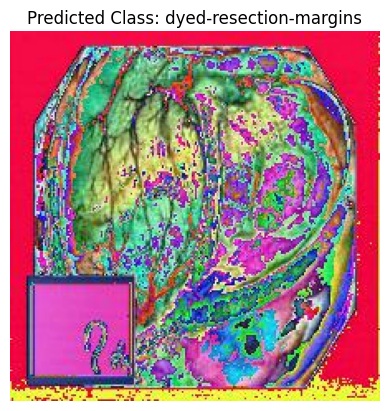

Similarity scores: {'dyed-lifted-polyps': 0.8699859380722046, 'dyed-resection-margins': 0.9997127652168274, 'esophagitis': 0.024313215166330338, 'normal-cecum': 0.00015561527106910944, 'normal-pylorus': 0.000618131656665355, 'normal-z-line': 0.009423719719052315, 'polyps': 0.0008409425499849021, 'ulcerative-colitis': 0.004507690668106079}
Predicted Class: dyed-resection-margins


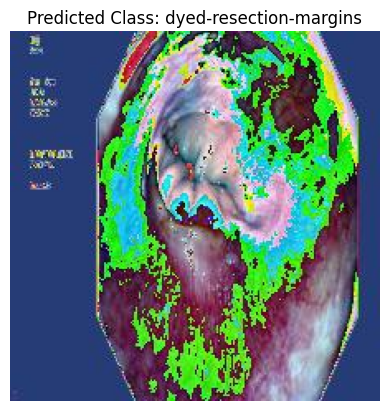

Similarity scores: {'dyed-lifted-polyps': 0.9751009345054626, 'dyed-resection-margins': 0.9998995065689087, 'esophagitis': 0.016469890251755714, 'normal-cecum': 0.00027073020464740694, 'normal-pylorus': 0.0008492411579936743, 'normal-z-line': 0.005391070619225502, 'polyps': 0.0013973002787679434, 'ulcerative-colitis': 0.010045998729765415}
Predicted Class: dyed-resection-margins


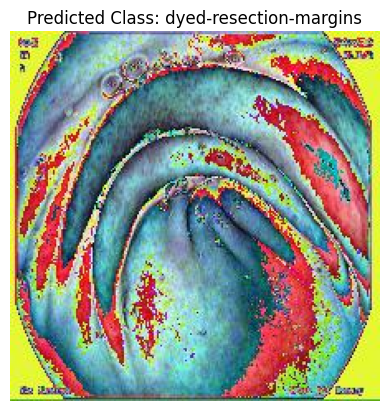

Similarity scores: {'dyed-lifted-polyps': 0.6991329789161682, 'dyed-resection-margins': 0.9930834770202637, 'esophagitis': 0.007625159807503223, 'normal-cecum': 0.0003060469462070614, 'normal-pylorus': 0.0008227645303122699, 'normal-z-line': 0.0015642138896510005, 'polyps': 0.00043292148620821536, 'ulcerative-colitis': 0.004455842077732086}
Predicted Class: dyed-resection-margins


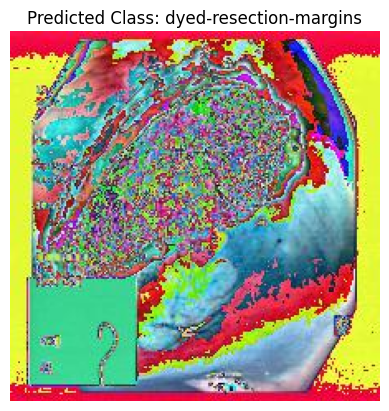

Similarity scores: {'dyed-lifted-polyps': 0.9483340978622437, 'dyed-resection-margins': 0.999901294708252, 'esophagitis': 0.028890525922179222, 'normal-cecum': 0.00043596557225100696, 'normal-pylorus': 0.000836922088637948, 'normal-z-line': 0.009222658351063728, 'polyps': 0.0014640933368355036, 'ulcerative-colitis': 0.012004154734313488}
Predicted Class: dyed-resection-margins


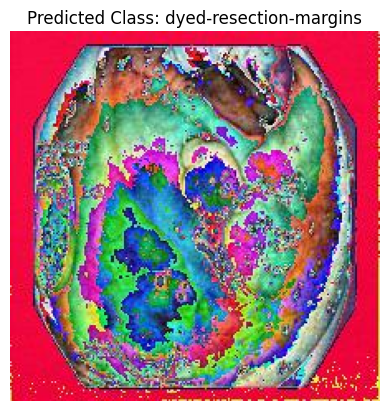

Similarity scores: {'dyed-lifted-polyps': 0.7762245535850525, 'dyed-resection-margins': 0.9991170763969421, 'esophagitis': 0.008265076205134392, 'normal-cecum': 7.44664212106727e-05, 'normal-pylorus': 0.0005211505340412259, 'normal-z-line': 0.0020671484526246786, 'polyps': 0.00029966176953166723, 'ulcerative-colitis': 0.0031167843844741583}
Predicted Class: dyed-resection-margins


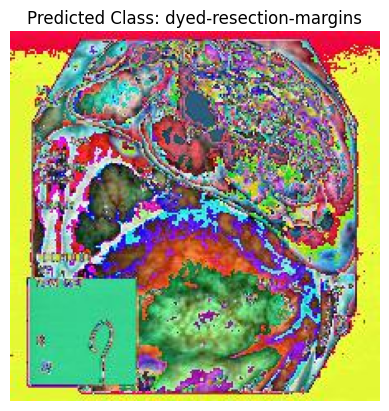

Similarity scores: {'dyed-lifted-polyps': 0.9821242690086365, 'dyed-resection-margins': 0.9999583959579468, 'esophagitis': 0.07909321784973145, 'normal-cecum': 0.0016911678249016404, 'normal-pylorus': 0.0024733617901802063, 'normal-z-line': 0.03498663380742073, 'polyps': 0.004284626338630915, 'ulcerative-colitis': 0.025541109964251518}
Predicted Class: dyed-resection-margins


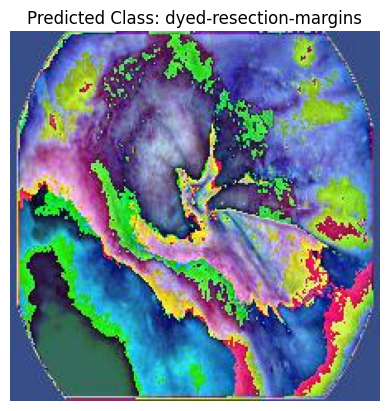

Similarity scores: {'dyed-lifted-polyps': 0.9230302572250366, 'dyed-resection-margins': 0.9997459053993225, 'esophagitis': 0.005859599448740482, 'normal-cecum': 9.64508144534193e-05, 'normal-pylorus': 0.0002193376567447558, 'normal-z-line': 0.0018689290154725313, 'polyps': 0.0004867931129410863, 'ulcerative-colitis': 0.004290647804737091}
Predicted Class: dyed-resection-margins


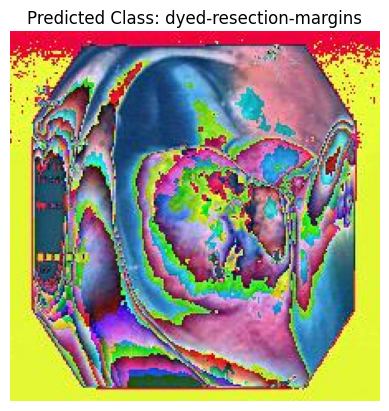

Similarity scores: {'dyed-lifted-polyps': 0.8764767050743103, 'dyed-resection-margins': 0.9996455907821655, 'esophagitis': 0.0062437644228339195, 'normal-cecum': 8.129838533932343e-05, 'normal-pylorus': 0.00025059047038666904, 'normal-z-line': 0.001454536453820765, 'polyps': 0.00043223347165621817, 'ulcerative-colitis': 0.004084502812474966}
Predicted Class: dyed-resection-margins


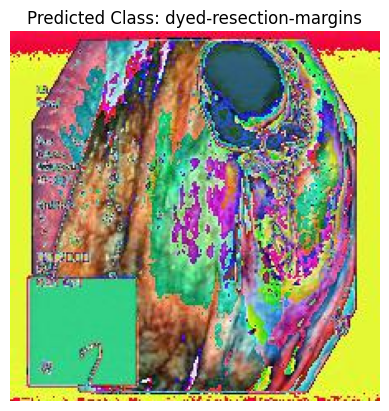

Similarity scores: {'dyed-lifted-polyps': 0.6114616394042969, 'dyed-resection-margins': 0.9986463189125061, 'esophagitis': 0.003538265824317932, 'normal-cecum': 2.540602690714877e-05, 'normal-pylorus': 9.808780305320397e-05, 'normal-z-line': 0.0011299223406240344, 'polyps': 0.00012904833420179784, 'ulcerative-colitis': 0.0010224423604086041}
Predicted Class: dyed-resection-margins


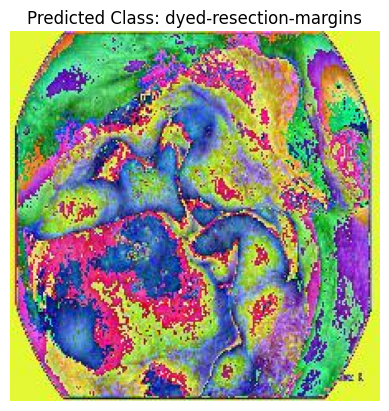

Similarity scores: {'dyed-lifted-polyps': 0.9900575280189514, 'dyed-resection-margins': 0.9999616146087646, 'esophagitis': 0.029831774532794952, 'normal-cecum': 0.0009081754833459854, 'normal-pylorus': 0.0014938198728486896, 'normal-z-line': 0.009457158856093884, 'polyps': 0.003293680725619197, 'ulcerative-colitis': 0.026944003999233246}
Predicted Class: dyed-resection-margins


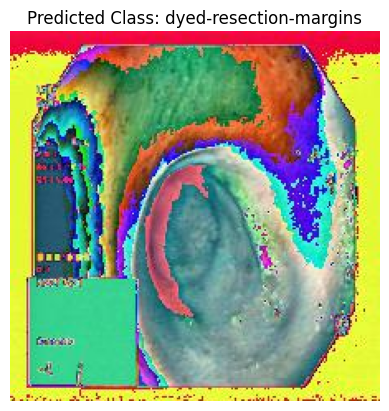

Similarity scores: {'dyed-lifted-polyps': 0.9245813488960266, 'dyed-resection-margins': 0.9998071789741516, 'esophagitis': 0.017381567507982254, 'normal-cecum': 0.0001795772695913911, 'normal-pylorus': 0.0006299807573668659, 'normal-z-line': 0.004371423274278641, 'polyps': 0.0009849308989942074, 'ulcerative-colitis': 0.011698427610099316}
Predicted Class: dyed-resection-margins


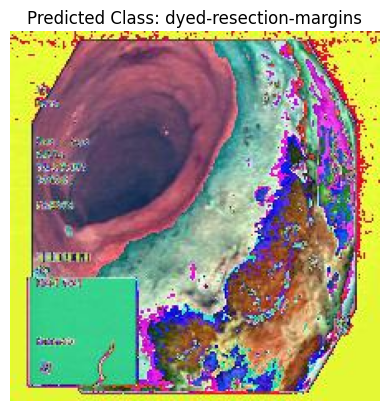

Model accuracy on the test subset: 12.50%


In [10]:
# Evaluating on the test subset.
evaluate_model(test_loader, trained_model, class_prototypes, class_names)